In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import networkx as nx
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph
from stellargraph import datasets
from SPARQLWrapper import SPARQLWrapper, JSON

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import  f1_score


from tensorflow.keras.callbacks import Callback
from keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tensorflow as tf


2022-03-21 16:24:42.596158: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-21 16:24:42.596189: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mossad-xps
2022-03-21 16:24:42.596195: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mossad-xps
2022-03-21 16:24:42.596269: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2022-03-21 16:24:42.596289: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.86.0
2022-03-21 16:24:42.596293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.86.0
2022-03-21 16:24:42.596545: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

In [9]:
# compute graph embeddings
eda_pip = ['http://kglids.org/resource/kaggle/residentmario.us-veteran-suicides/syedalimohsinbukhari-us-veteran-dataset-analysis-us-veteran-dataset-analysis', 
           'http://kglids.org/resource/kaggle/nasa.landslide-events/alexisbcook-parsing-dates-parsing-dates', 
           'http://kglids.org/resource/kaggle/nasa.landslide-events/julianjoseph-datathon-day-2-datathon-day-2', 
           'http://kglids.org/resource/kaggle/kulgen.elon-musks-tweets/shubhamrshirude-topic-modelling-lda-topic-modelling-lda', 
           'http://kglids.org/resource/kaggle/kulgen.elon-musks-tweets/esthercao-covid-tweets-sentiment-analysis-and-trends-covid-tweets-sentiment-analysis-and-trends',
           'http://kglids.org/resource/kaggle/minatverma.nse-stocks-data/captainqq-doge-price-prediction-with-lstm-network-doge-price-prediction-with-lstm-network', 
           'http://kglids.org/resource/kaggle/minatverma.nse-stocks-data/stpeteishii-nse-stock-prediction-pycaret-nse-stock-prediction-pycaret']
ml_pip = ['http://kglids.org/resource/kaggle/kulgen.elon-musks-tweets/duhduh-tweets-and-stock-price-tweets-and-stock-price', 
          'http://kglids.org/resource/kaggle/sammy123.lower-back-pain-symptoms-dataset/amithasanshuvo-lower-back-pain-classification-lower-back-pain-classification', 
          'http://kglids.org/resource/kaggle/sammy123.lower-back-pain-symptoms-dataset/sagarsharma4244-88-3-accuracy-simple-ml-models-88-3-accuracy-simple-ml-models', 
          'http://kglids.org/resource/kaggle/sammy123.lower-back-pain-symptoms-dataset/nileshvarshney1-lower-back-pain-analysis-lower-back-pain-analysis', 
          'http://kglids.org/resource/kaggle/yersever.500-person-gender-height-weight-bodymassindex/allysonvasquez-prediction-w-multiple-linear-regression-prediction-w-multiple-linear-regression', 
          'http://kglids.org/resource/kaggle/imoore.60k-stack-overflow-questions-with-quality-rate/rajacsp-linear-equations-and-numpy-real-time-linear-equations-and-numpy-real-time', 
          'http://kglids.org/resource/kaggle/imoore.60k-stack-overflow-questions-with-quality-rate/kshitijmohan-nlp-word-embedding-glove-vs-model-bert-93-acc-nlp-word-embedding-glove-vs-model-bert-93-acc', ]
pips = eda_pip+ml_pip

for pip in pips:
    query = """
                                     select  ?subject ?predicate ?object
                                     where {
                                       graph <PLACEHOLDER> {?subject ?predicate ?object}
                                     }
                                  """.replace('PLACEHOLDER', pip)
    kglids_endpoint = 'http://localhost:5858/kglids/query'
    sparql = SPARQLWrapper(kglids_endpoint, returnFormat=JSON)
    sparql.setCredentials('admin', 'admin')
    sparql.setQuery(query)
    results = sparql.query().convert()
    spo = []
    print(results['results']['bindings'][:150])
    break
    for result in results["results"]["bindings"]:
        if result['subject']["type"] == 'uri':
            subj, pred, obj = result['subject']['value'], result['predicate']["value"].strip(), result['object']["value"]
        else:
            subj, pred, obj = result['subject']['s']['value'], result['subject']['p']['value'], result['subject']['o']['value']
        spo.append([subj, pred, obj])
    df = pd.DataFrame(spo, columns=['s', 'p', 'o'])
    file_name = pip.lstrip('http://kglids.org/resource/kaggle/')+'.tsv'
    os.makedirs(file_name.split('/')[0], exist_ok=True)
    df.to_csv(file_name, index=False, sep='\t')

[{'predicate': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, 'subject': {'type': 'uri', 'value': 'http://kglids.org/resource/kaggle/residentmario.us-veteran-suicides/us-veteran-dataset-analysis.py'}, 'object': {'type': 'uri', 'value': 'http://kglids.org/ontology/Pipeline'}}, {'predicate': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, 'subject': {'type': 'uri', 'value': 'http://kglids.org/resource/kaggle/residentmario.us-veteran-suicides'}, 'object': {'type': 'uri', 'value': 'http://kglids.org/ontology/Dataset'}}, {'predicate': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, 'subject': {'type': 'uri', 'value': 'http://kglids.org/resource/kaggle/residentmario.us-veteran-suicides/us-veteran-dataset-analysis.py/s1'}, 'object': {'type': 'uri', 'value': 'http://kglids.org/ontology/Statement'}}, {'predicate': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, 'subject': {'type'

# Read Graphs: Stardog --> Networkx

In [14]:
def rdf_to_networkx(sparql_endpoint):
    # Returns all graphs in a sparql endpoint as a dictionary: {graph_uri : nx.DiGraph}  
    get_all_graph_triples_query = """
                                     select distinct ?graph ?subject ?predicate ?object
                                     where {
                                       graph ?graph {?subject ?predicate ?object}
                                     }
                                  """
    sparql = SPARQLWrapper(sparql_endpoint, returnFormat=JSON)
    sparql.setCredentials('admin', 'admin')
    sparql.setQuery(get_all_graph_triples_query)
    results = sparql.query().convert()
    
    graphs = {}
    for result in tqdm(results["results"]["bindings"]):
        graph_uri = result['graph']["value"]
        if graph_uri not in graphs:
            graphs[graph_uri] = nx.DiGraph()

        g = graphs[graph_uri]
        
        # RDF-star triples are edge properties
        if result['subject']["type"] == 'uri':
            subj, pred, obj = result['subject']['value'], result['predicate']["value"].strip(), result['object']["value"]
            g.add_edge(subj, obj, type=pred)
        else:
            subj, pred, obj = result['subject']['s']['value'], result['subject']['p']['value'], result['subject']['o']['value']
            star_pred, star_obj = result['predicate']["value"].strip(), result['object']["value"]
            g.add_edge(subj, obj, **{'type': pred, star_pred: star_obj})
    
    # add random node features of size feature_size
#     feature_size = 16
#     for g in graphs.values():
#         for i in g.nodes():
#             g.nodes[i]['features'] = np.random.normal(size=(1,feature_size)).tolist()[0]

# convert to StellarGraph
#     for k in graphs.keys():
#         graphs[k] = sg.StellarDiGraph.from_networkx(graphs[k], edge_type_attr='type', node_features='features')
    
    return graphs

In [15]:
kglids_endpoint = 'http://localhost:5820/kglids_1000/query'
graph4code_endpoint = 'http://localhost:5820/graph4code_1000/query'

if os.path.exists('kglids_nx_tmp.pkl') and os.path.exists('g4c_nx_tmp.pkl'):
    kglids_nx, graph4code_nx = pd.read_pickle('kglids_nx_tmp.pkl'), pd.read_pickle('g4c_nx_tmp.pkl')
else:
    kglids_nx = rdf_to_networkx(kglids_endpoint)
    with open('kglids_nx_tmp.pkl', 'wb') as f:
        pickle.dump(kglids_nx, f)
    graph4code_nx = rdf_to_networkx(graph4code_endpoint)
    with open('g4c_nx_tmp.pkl', 'wb') as f:
        pickle.dump(graph4code_nx, f)

# Learn Embeddings for Each Graph

In [ ]:
for graph_uri, graph in kglids_nx.items():
    graph_spo = 
model = TransE(batches_count=10,epochs=20,k=embedding_size, eta=20,
                    optimizer='adam', optimizer_params={'lr':1e-2},loss='multiclass_nll',regularizer='LP', 
                    regularizer_params={'p':3, 'lambda':1e-2}, verbose=True)

In [16]:
# make sure graphs are the same for kglids and g4c
# print(f'Before alignment: {len(kglids_stellargraph)=} - {len(graph4code_stellargraph)=}')
for k in list(kglids_stellargraph.keys()):
    if k not in graph4code_stellargraph:
        kglids_stellargraph.pop(k)
for k in list(graph4code_stellargraph.keys()):
    if k not in kglids_stellargraph:
        graph4code_stellargraph.pop(k)

# print(f'After alignment:  {len(kglids_stellargraph)=} - {len(graph4code_stellargraph)=}')

# read the labels
labels_df = pd.read_csv('pipeline_classification_ground_truth.csv')
print('Total of:', len(kglids_stellargraph), 'pipelines.')
print('Labels Distribution:')
print(labels_df.target.value_counts())
labels_df.target = labels_df.target.replace({'eda': 0, 'ml': 1, 'none': 2})
labels_map = labels_df.set_index('pipeline').to_dict(orient='index')

kglids_graphs = []
g4c_graphs = []
labels = []
for k in sorted(kglids_stellargraph.keys()):
    kglids_graphs.append(kglids_stellargraph[k])
    g4c_graphs.append(graph4code_stellargraph[k])
    labels.append(labels_map[k]['target'])

Total of: 935 pipelines.
Labels Distribution:
eda     592
ml      250
none     97
Name: target, dtype: int64


### Split to Train / Test

In [17]:
kglids_train_graphs, kglids_test_graphs, g4c_train_graphs, g4c_test_graphs, train_labels, test_labels = \
train_test_split(kglids_graphs, g4c_graphs, labels, train_size=0.9, stratify=labels, random_state=3)

## Graph Classification model

In [21]:
class Metrics(Callback):
    def __init__(self, model, valid_data, true_outputs):
        super(Callback, self).__init__()
        self.model=model
        self.valid_data=valid_data    #the validation data I'm getting metrics on
        self.true_outputs=true_outputs    #the ground truth of my validation data
        self.steps=len(self.valid_data)

    def from_proba_to_output(self, probabilities, threshold):
        outputs = np.copy(probabilities)
        for i in range(len(outputs)):

            if (float(outputs[i])) > threshold:
                outputs[i] = int(1)
            else:
                outputs[i] = int(0)
        return np.array(outputs)

    def on_epoch_end(self, args,*kwargs):
        gen=generator(self.valid_data)     #generator yielding the validation data
        val_predict = (np.asarray(self.model.predict(gen, batch_size=1, verbose=0, steps=self.steps)))

        """
        The function from_proba_to_output is used to transform probabilities  
        into an understandable format by sklearn's f1_score function
        """
        val_predict=self.from_proba_to_output(val_predict, 0.5)
        _val_f1 = f1_score(self.true_outputs, val_predict)
        print ("val_f1: ", _val_f1, "   val_precision: ", _val_precision, "   _val_recall: ", _val_recall)

def train_and_evaluate_classification_model(train_graphs, test_graphs, train_labels, test_labels, epochs=100):
    gen = PaddedGraphGenerator(graphs=train_graphs+test_graphs)
    k = 35  # the number of rows for the output tensor
    layer_sizes = [32, 32, 32, 1]

    dgcnn_model = DeepGraphCNN(
        layer_sizes=layer_sizes,
        activations=["tanh", "tanh", "tanh", "tanh"],
        k=k,
        bias=False,
        generator=gen,
    )
    x_inp, x_out = dgcnn_model.in_out_tensors()

    x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
    x_out = MaxPool1D(pool_size=2)(x_out)

    x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

    x_out = Flatten()(x_out)

    x_out = Dense(units=128, activation="relu")(x_out)
    x_out = Dropout(rate=0.25)(x_out)

    predictions = Dense(units=1, activation="sigmoid")(x_out)

    model = Model(inputs=x_inp, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.1), loss=categorical_crossentropy, metrics=["acc"])
    

    train_gen = gen.flow(
        graphs=train_graphs,
        targets=train_labels,
        batch_size=50,
        symmetric_normalization=False,
    )

    test_gen = gen.flow(
        graphs=test_graphs,
        targets=test_labels,
        batch_size=1,
        symmetric_normalization=False,
    )
    
    # fit
    history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True)#, callbacks=[Metrics(model, test_graphs, test_labels)])
    sg.utils.plot_history(history)
    
    # evaluate on test
    test_metrics = model.evaluate(test_gen)
    print("\nTest Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))
    print(model.predict(test_graphs))


## KGLiDS:

Epoch 1/20


/home/mossad/anaconda3/envs/kglids/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/sort_pooling_2/map/while/gradients/model_2/sort_pooling_2/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/sort_pooling_2/map/while/gradients/model_2/sort_pooling_2/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/sort_pooling_2/map/while/gradients/model_2/sort_pooling_2/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


17/17 [==============================] - 26s 1s/step - loss: 0.0000e+00 - acc: 0.6112 - val_loss: 0.0000e+00 - val_acc: 0.6277
Epoch 2/20
17/17 [==============================] - 25s 1s/step - loss: 0.0000e+00 - acc: 0.6278 - val_loss: 0.0000e+00 - val_acc: 0.6277
Epoch 3/20
17/17 [==============================] - 25s 1s/step - loss: 0.0000e+00 - acc: 0.6266 - val_loss: 0.0000e+00 - val_acc: 0.6277
Epoch 4/20
17/17 [==============================] - 25s 1s/step - loss: 0.0000e+00 - acc: 0.6266 - val_loss: 0.0000e+00 - val_acc: 0.6277
Epoch 5/20
17/17 [==============================] - 24s 1s/step - loss: 0.0000e+00 - acc: 0.6302 - val_loss: 0.0000e+00 - val_acc: 0.6277
Epoch 6/20
17/17 [==============================] - 25s 1s/step - loss: 0.0000e+00 - acc: 0.6302 - val_loss: 0.0000e+00 - val_acc: 0.6277
Epoch 7/20
17/17 [==============================] - 25s 2s/step - loss: 0.0000e+00 - acc: 0.6278 - val_loss: 0.0000e+00 - val_acc: 0.6277
Epoch 8/20
17/17 [===========================

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'stellargraph.core.graph.StellarDiGraph'>"}), <class 'NoneType'>

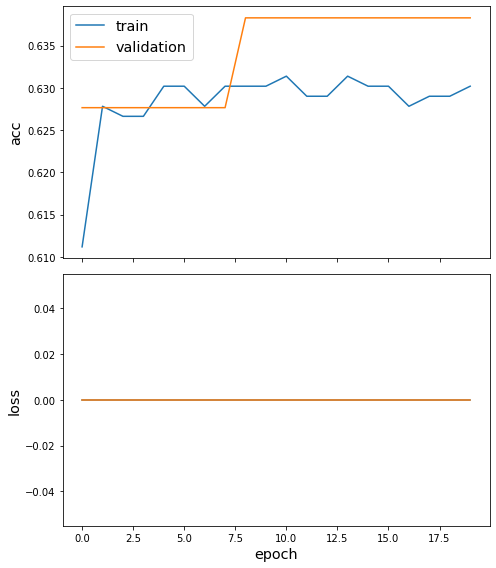

In [22]:
train_and_evaluate_classification_model(kglids_train_graphs, kglids_test_graphs, train_labels, test_labels, epochs=20)

## GraphGen4Code:

In [26]:
train_and_evaluate_classification_model(g4c_train_graphs, g4c_test_graphs, train_labels, test_labels, epochs=5)

KeyboardInterrupt: 